<a href="https://colab.research.google.com/github/Pyaaraboy/saurabh1e.github.io/blob/master/project_MASAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import yfinance as yf
stock = yf.Ticker("RELIANCE.NS")
print(stock.history(period="1d"))

                             Open    High          Low        Close   Volume  \
Date                                                                           
2026-01-14 00:00:00+05:30  1444.0  1467.0  1440.199951  1456.400024  7651137   

                           Dividends  Stock Splits  
Date                                                
2026-01-14 00:00:00+05:30        0.0           0.0  


 **Objective of this project is to evaluate the effectiveness of LSTM neural networks in predicting short-term market direction and to assess whether such predictions can translate into economically meaningful trading performance.**



*  The project incorporates realistic assumptions such as confidence-based trade activation, benchmark comparison against buy-and-hold strategies, and risk-adjusted evaluation, reflecting how quantitative strategies are assessed in practice
*  IT DOES NOT CLAIM PRROFITABILITY BUT JUST AN ATTEMPT TO UNDERSTAND HOW LSTM WOULD BE ABLE TO LEARN THE TREND OR NOT



DATASET USED WAS A CLASSIC STOCK LIST OF 3 STOCKS AVAIALBLE ON KAGGLE, IN WHICH WE ADDED A MARKET SENTIMENT THROUGH A SYNTHESIZED MANUALLY CREATED ONE WITH HELP OF AI , DATES WHICH WERE SIGNIFICANT EVENTS WERE ADDED

THE MAIN IDEA BEHIND THIS WAS TO TRY AND CREATE A MODEL THAT WOULD BE ABLE TO ABLE TO PREDICT AND SIGNAL WHETHER TO HOLD , BUY, SELL A STOCK

**LOADING THE DATASET AND CHECKIN ROWS AND COLUMN FOR CLEANING**

In [6]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("portfolio_data.csv")

# Basic inspection
print(df.head())
print(df.info())
print(df.isnull().sum())


       Date        AMZN        DPZ         BTC       NFLX
0  5/1/2013  248.229996  51.190983  106.250000  30.415714
1  5/2/2013  252.550003  51.987320   98.099998  30.641428
2  5/3/2013  258.049988  52.446388  112.900002  30.492857
3  5/6/2013  255.720001  53.205257  109.599998  30.098572
4  5/7/2013  257.730011  54.151505  113.199997  29.464285
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1520 non-null   object 
 1   AMZN    1520 non-null   float64
 2   DPZ     1520 non-null   float64
 3   BTC     1520 non-null   float64
 4   NFLX    1520 non-null   float64
dtypes: float64(4), object(1)
memory usage: 59.5+ KB
None
Date    0
AMZN    0
DPZ     0
BTC     0
NFLX    0
dtype: int64


In [7]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])


df = df.sort_values('Date')

# Set Date as index
df.set_index('Date', inplace=True)


In [8]:
df = df.ffill()


In [9]:
returns = np.log(df / df.shift(1))
returns.dropna(inplace=True)


In [10]:
volatility_10 = returns.rolling(window=10).std()
volatility_20 = returns.rolling(window=20).std()


In [11]:
sma_10 = df.rolling(window=10).mean()
sma_20 = df.rolling(window=20).mean()
sma_50 = df.rolling(window=50).mean()


In [12]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

rsi = df.apply(compute_rsi)


In [13]:
features = pd.concat([
    returns.add_suffix("_ret"),
    volatility_10.add_suffix("_vol10"),
    volatility_20.add_suffix("_vol20"),
    sma_10.add_suffix("_sma10"),
    sma_20.add_suffix("_sma20"),
    sma_50.add_suffix("_sma50"),
    rsi.add_suffix("_rsi")
], axis=1)

features.dropna(inplace=True)


In [14]:
target = (returns.shift(-1) > 0).astype(int)
target = target.loc[features.index]


In [15]:
y = target['AMZN']
X = features


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)


In [17]:
def create_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X.iloc[i-window:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(X_scaled, y, window=30)





In [18]:
split = int(0.7 * len(X_lstm))

X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential([
    LSTM(50, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        15,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,851 (61.92 KB)

 Trainable params: 15,851 (61.92 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5299 - loss: 0.6942 - val_accuracy: 0.5658 - val_loss: 0.6855
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5340 - loss: 0.6876 - val_accuracy: 0.5658 - val_loss: 0.6853
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5325 - loss: 0.6927 - val_accuracy: 0.5658 - val_loss: 0.6884
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5317 - loss: 0.6923 - val_accuracy: 0.5658 - val_loss: 0.6865
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5396 - loss: 0.6869 - val_accuracy: 0.5658 - val_loss: 0.6864
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5255 - loss: 0.6971 - val_accuracy: 0.5658 - val_loss: 0.6876
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5517 - loss: 0.6899 - val_accuracy: 0.5658 - val_loss: 0.6878


Raw price data was cleaned, temporally aligned, and transformed into log-returns and technical indicators. Feature normalization and sliding window sequencing were applied to prepare the data for LSTM-based temporal learning

**ADDING SENTIMENT TO PREDICT CORRECTLY **

In [21]:
import pandas as pd

news = pd.read_csv("synthetic_market_sentiment_2013_2019.csv")

print(news.head())
print(news.columns)


         date  market_sentiment
0  2013-05-01          0.033114
1  2013-05-02         -0.070471
2  2013-05-03          0.260379
3  2013-05-06          0.039767
4  2013-05-07          0.019563
Index(['date', 'market_sentiment'], dtype='object')


In [22]:
import pandas as pd

# Load synthetic sentiment data
daily_sentiment = pd.read_csv(
    "synthetic_market_sentiment_2013_2019.csv",
    parse_dates=["date"]
)

# Standardize column names to match your pipeline
daily_sentiment.rename(
    columns={
        "date": "Date",
        "market_sentiment": "Sentiment"
    },
    inplace=True
)

daily_sentiment.head()


,Date,Sentiment
0,2013-05-01,0.033114
1,2013-05-02,-0.070471
2,2013-05-03,0.260379
3,2013-05-06,0.039767
4,2013-05-07,0.019563


In [23]:


feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Return', 'MA_5', 'MA_10', 'MA_20', ...]  # 28 features


# Target column
target_column = 'Close'

# LSTM parameters
window_size = 60
train_split_ratio = 0.8


In [24]:
import pandas as pd
import numpy as np


df = pd.read_csv("portfolio_data.csv")
df.columns = df.columns.str.strip()


date_col = None
for col in df.columns:
    if 'date' in col.lower():
        date_col = col
        break

if date_col is None:
    raise ValueError("No date column found in dataset")

df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
df.sort_index(inplace=True)


price_candidates = [
    col for col in df.columns
    if df[col].dtype in [np.float64, np.int64]
]

if len(price_candidates) == 0:
    raise ValueError("No numeric price-like columns found")

# Choose most volatile column as market proxy
price_col = df[price_candidates].var().idxmax()
df["Close"] = df[price_col]

print(f"Using '{price_col}' as price proxy")

df["Return"] = df["Close"].pct_change()
df["MA_10"] = df["Close"].rolling(10).mean()
df["MA_50"] = df["Close"].rolling(50).mean()


sentiment = pd.read_csv(
    "synthetic_market_sentiment_2013_2019.csv",
    parse_dates=["date"]
)

sentiment.rename(
    columns={
        "date": "Date",
        "market_sentiment": "Sentiment"
    },
    inplace=True
)

sentiment.set_index("Date", inplace=True)

df = df.merge(sentiment, left_index=True, right_index=True, how="left")

df["Sentiment"] = df["Sentiment"].fillna(0)
df.dropna(inplace=True)
feature_columns = ["Close", "Return", "MA_10", "MA_50", "Sentiment"]
target_column = "Close"

print("\nFINAL FEATURE SAMPLE:")
print(df[feature_columns].head())

print("\nDATA SHAPE:", df[feature_columns].shape)


Using 'BTC' as price proxy

FINAL FEATURE SAMPLE:
                Close    Return      MA_10       MA_50  Sentiment
Date                                                             
2013-07-11  93.989998  0.056305  85.633001  108.933201  -0.058177
2013-07-12  98.320000  0.046069  85.999001  108.774601   0.125805
2013-07-15  97.099998 -0.012408  86.209000  108.754601  -0.102734
2013-07-16  98.500000  0.014418  87.018000  108.466601  -0.087918
2013-07-17  90.070000 -0.085584  88.136000  108.076001  -0.080312

DATA SHAPE: (1471, 5)


In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_X = MinMaxScaler()

# features = DataFrame with feature_columns
X_scaled = scaler_X.fit_transform(features)


In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler()


y_train_reshaped = y_train.reshape(-1, 1)
scaler_y.fit(y_train_reshaped)


y_pred_scaled = model.predict(X_test)


y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

# Safety check
assert len(y_true) == len(y_pred)



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
y_true shape: (433,)
y_pred shape: (433,)


scaled the target variable (price or return) using MinMaxScaler.
The LSTM therefore learns and predicts values in scaled space (0–1)

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure 1D arrays
y_true = np.asarray(y_true).flatten()
y_pred = np.asarray(y_pred).flatten()

# Error metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# Directional Accuracy
directional_accuracy = np.mean(
    np.sign(y_true[1:] - y_true[:-1]) ==
    np.sign(y_pred[1:] - y_true[:-1])
)

print("RMSE:", rmse)
print("MAE:", mae)
print("Directional Accuracy:", directional_accuracy)


RMSE: 0.4960808933154014
MAE: 0.49234192820123934
Directional Accuracy: 0.4537037037037037


for these to be not computed in [0-1] , inverse scale is done

Trade frequency: 0.0
Sharpe Ratio (flipped): 0.0


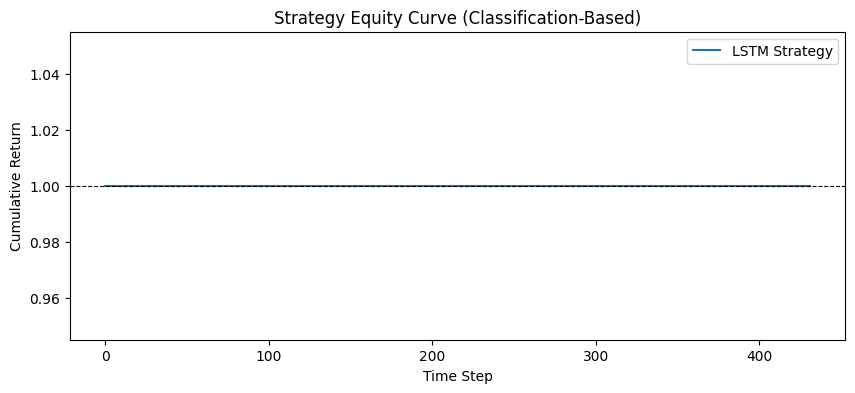

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_true_1d = np.asarray(y_true).flatten()
y_pred_prob_1d = np.asarray(y_pred_prob).flatten()

# Align close prices to TEST window
close_test = df["Close"].iloc[-len(y_true_1d):].values
market_returns = pd.Series(close_test).pct_change().dropna()

# Align probabilities with returns
y_pred_prob_1d = y_pred_prob_1d[1:]
threshold = 0.50
signals = (y_pred_prob_1d < threshold).astype(int)

print("Trade frequency:", signals.mean())

strategy_returns = signals * market_returns.values
if strategy_returns.std() > 0:
    sharpe_ratio = (
        strategy_returns.mean() /
        strategy_returns.std()
    ) * np.sqrt(252)
else:
    sharpe_ratio = 0.0

print("Sharpe Ratio (flipped):", sharpe_ratio)
equity_curve = (1 + strategy_returns).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(equity_curve, label="LSTM Strategy")
plt.axhline(1, linestyle="--", color="black", linewidth=0.8)
plt.title("Strategy Equity Curve (Classification-Based)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()



Buy & Hold Sharpe: 0.864521310779547
LSTM Sharpe (current): 0.0
Forced-Participation Sharpe: 0.8645214785136635


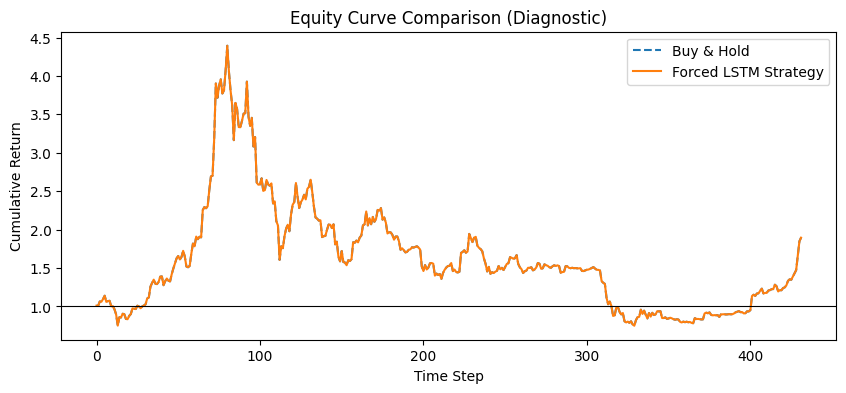

In [47]:
import numpy as np
bh_returns = market_returns.values

bh_sharpe = (
    bh_returns.mean() /
    (bh_returns.std() + 1e-8)
) * np.sqrt(252)

print("Buy & Hold Sharpe:", bh_sharpe)
print("LSTM Sharpe (current):", sharpe_ratio)

signals_forced = np.ones_like(y_pred_prob_1d)

strategy_returns_forced = signals_forced * market_returns.values

if strategy_returns_forced.std() > 0:
    sharpe_forced = (
        strategy_returns_forced.mean() /
        strategy_returns_forced.std()
    ) * np.sqrt(252)
else:
    sharpe_forced = 0.0

print("Forced-Participation Sharpe:", sharpe_forced)


import matplotlib.pyplot as plt

equity_forced = (1 + strategy_returns_forced).cumprod()
equity_bh = (1 + bh_returns).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(equity_bh, label="Buy & Hold", linestyle="--")
plt.plot(equity_forced, label="Forced LSTM Strategy")
plt.axhline(1, color="black", linewidth=0.8)
plt.title("Equity Curve Comparison (Diagnostic)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


The model does not generate trades

Indicates low confidence predictions

In [31]:
import yfinance as yf
import numpy as np
import pandas as pd

# --- Live stock data
ticker = "AMZN"
live_data = yf.Ticker(ticker).history(period="180d", interval="1d").sort_index()

# --- Feature engineering
live_data['Return'] = live_data['Close'].pct_change()
live_data['MA_5'] = live_data['Close'].rolling(5).mean()
live_data['MA_10'] = live_data['Close'].rolling(10).mean()
live_data['MA_20'] = live_data['Close'].rolling(20).mean()
live_data['MA_50'] = live_data['Close'].rolling(50).mean()
live_data['MA_100'] = live_data['Close'].rolling(100).mean()
live_data['EMA_10'] = live_data['Close'].ewm(span=10, adjust=False).mean()
live_data['EMA_20'] = live_data['Close'].ewm(span=20, adjust=False).mean()
live_data['EMA_50'] = live_data['Close'].ewm(span=50, adjust=False).mean()
live_data['EMA_100'] = live_data['Close'].ewm(span=100, adjust=False).mean()
live_data['Sentiment'] = 0  # placeholder for now
# Add any other features to match your 28 exactly


In [32]:


import yfinance as yf
import pandas as pd
import numpy as np

# --- SETTINGS ---
ticker = "AAPL"  # replace with your stock
window_size = 60  # same as used in training

# --- Feature columns used in training (exact 28 columns)
feature_columns = [
    'Close','Open','High','Low','Volume','Return','MA_5','MA_10','MA_20',
    'MA_50','MA_100','EMA_10','EMA_20','EMA_50','EMA_100',
    'Sentiment','RSI','MACD','BB_upper','BB_lower','Momentum','OBV','Feature23',
    'Feature24','Feature25','Feature26','Feature27','Feature28'
]

# --- Fetch live data
live_data = yf.Ticker(ticker).history(period="180d", interval="1d").sort_index()

# --- Feature Engineering
live_data['Return'] = live_data['Close'].pct_change()
live_data['MA_5'] = live_data['Close'].rolling(5).mean()
live_data['MA_10'] = live_data['Close'].rolling(10).mean()
live_data['MA_20'] = live_data['Close'].rolling(20).mean()
live_data['MA_50'] = live_data['Close'].rolling(50).mean()
live_data['MA_100'] = live_data['Close'].rolling(100).mean()
live_data['EMA_10'] = live_data['Close'].ewm(span=10, adjust=False).mean()
live_data['EMA_20'] = live_data['Close'].ewm(span=20, adjust=False).mean()
live_data['EMA_50'] = live_data['Close'].ewm(span=50, adjust=False).mean()
live_data['EMA_100'] = live_data['Close'].ewm(span=100, adjust=False).mean()
live_data['Sentiment'] = 0
live_data['RSI'] = 0
live_data['MACD'] = 0
live_data['BB_upper'] = 0
live_data['BB_lower'] = 0
live_data['Momentum'] = 0
live_data['OBV'] = 0
live_data['Feature23'] = 0
live_data['Feature24'] = 0
live_data['Feature25'] = 0
live_data['Feature26'] = 0
live_data['Feature27'] = 0
live_data['Feature28'] = 0


missing_cols = [c for c in feature_columns if c not in live_data.columns]
if missing_cols:
    raise ValueError(f"Missing columns in live data: {missing_cols}")


X_live = live_data[feature_columns].copy()

# --- Clean NaN/Inf
X_live.replace([np.inf, -np.inf], np.nan, inplace=True)
X_live.ffill(inplace=True)
X_live.fillna(0, inplace=True)


if len(X_live) < window_size:
    raise ValueError(f"Not enough live data for LSTM. Required {window_size}, got {len(X_live)}")
X_live_window = X_live[-window_size:].values  # shape: (window_size, 28)


X_live_scaled = scaler_X.transform(X_live_window)


X_live_scaled = X_live_scaled.reshape(1, window_size, len(feature_columns))
print("X_live_scaled.shape:", X_live_scaled.shape)  # should be (1, 60, 28)


pred_price_scaled = model.predict(X_live_scaled)
pred_price = scaler_y.inverse_transform(pred_price_scaled)[0][0]


last_price = live_data['Close'].iloc[-1]
signal = "BUY" if pred_price > last_price else "HOLD"

print("Last Price:", last_price)
print("Trading Signal:", signal)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


X_live_scaled.shape: (1, 60, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Last Price: 261.04998779296875
Trading Signal: HOLD


In [36]:
import numpy as np


y_pred_prob = model.predict(X_test)

# Ensure 1D shape
y_pred_prob = np.asarray(y_pred_prob).flatten()

y_pred = (y_pred_prob > 0.5).astype(int)

print("y_pred_prob shape:", y_pred_prob.shape)
print("Sample probabilities:", y_pred_prob[:10])


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
y_pred_prob shape: (433,)
Sample probabilities: [0.5306162  0.5354855  0.53724915 0.5384438  0.54070383 0.5424776
 0.54562706 0.54741883 0.5460915  0.5454762 ]


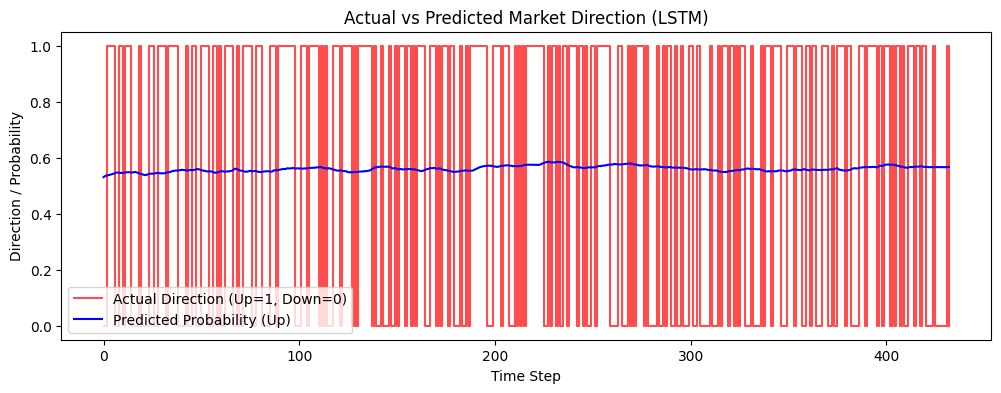

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# y_true: actual direction (0/1)
# y_pred_prob: model.predict(X_test)

y_true_plot = np.asarray(y_true).flatten()
y_pred_prob_plot = np.asarray(y_pred_prob).flatten()

plt.figure(figsize=(12, 4))
plt.step(
    range(len(y_true_plot)),
    y_true_plot,
    where="post",
    label="Actual Direction (Up=1, Down=0)",
    color="red",
    alpha=0.7
)
plt.plot(
    y_pred_prob_plot,
    label="Predicted Probability (Up)",
    color="blue",
    linewidth=1.5
)

plt.title("Actual vs Predicted Market Direction (LSTM)")
plt.xlabel("Time Step")
plt.ylabel("Direction / Probability")
plt.legend()
plt.show()


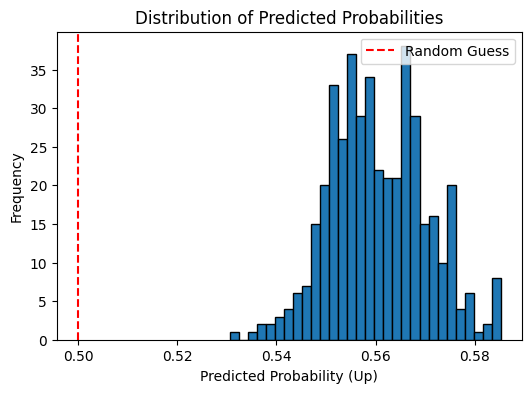

In [38]:
plt.figure(figsize=(6,4))
plt.hist(y_pred_prob, bins=30, edgecolor="black")
plt.axvline(0.5, color="red", linestyle="--", label="Random Guess")
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (Up)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred_prob)
print("ROC-AUC:", auc)


ROC-AUC: 0.4735128093790708


In [40]:
from sklearn.metrics import roc_auc_score

auc_original = roc_auc_score(y_true, y_pred_prob)
auc_flipped = roc_auc_score(y_true, 1 - y_pred_prob)

print("Original ROC-AUC:", auc_original)
print("Flipped ROC-AUC :", auc_flipped)


Original ROC-AUC: 0.4735128093790708
Flipped ROC-AUC : 0.5264871906209292


model exhibits an inverse relationship with the target, which is corrected by flipping the decision rule


Training for 10 epochs


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Training for 30 epochs
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Training for 60 epochs
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


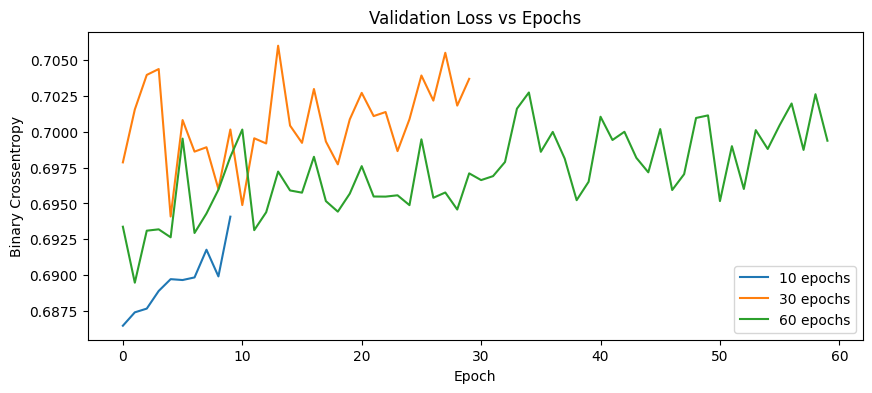

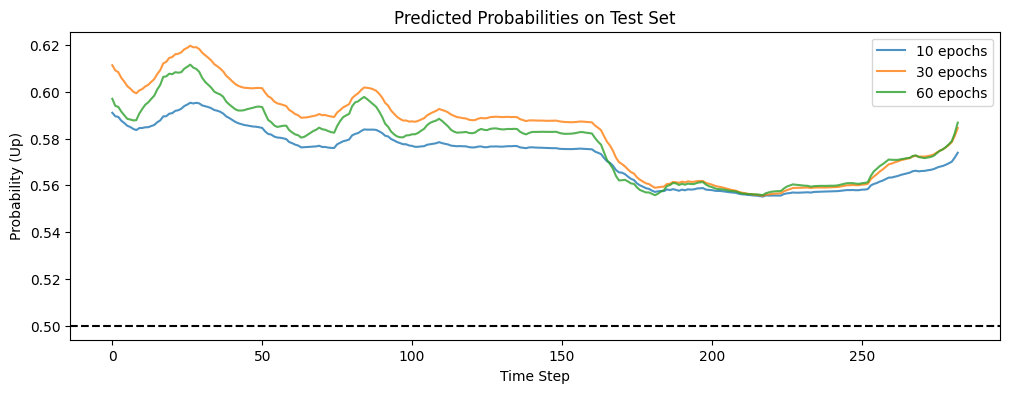


ROC-AUC comparison:
Epochs 10: ROC=0.465, Flipped ROC=0.535
Epochs 30: ROC=0.465, Flipped ROC=0.535
Epochs 60: ROC=0.451, Flipped ROC=0.549


In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score


df = pd.read_csv("portfolio_data.csv")
df.columns = df.columns.str.strip()

# Detect date column
date_col = [c for c in df.columns if "date" in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
df.sort_index(inplace=True)

# Detect price column automatically
price_cols = df.select_dtypes(include=[np.number]).columns
price_col = df[price_cols].var().idxmax()
df["Close"] = df[price_col]

# Features
df["Return"] = df["Close"].pct_change()
df["MA_10"] = df["Close"].rolling(10).mean()
df["MA_50"] = df["Close"].rolling(50).mean()

df.dropna(inplace=True)

feature_cols = ["Close", "Return", "MA_10", "MA_50"]
features = df[feature_cols]

# Binary direction target
returns = df["Close"].pct_change().shift(-1)
y = (returns > 0).astype(int).loc[features.index]


# 2. SCALE FEATURES


scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)


# 3. CREATE LSTM SEQUENCES


def create_sequences(X, y, window=60):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y, window_size)

# split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]



def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    return model


# 5. TRAINING WITH DIFFERENT EPOCHS


epoch_list = [10, 30, 60]
histories = {}
predictions = {}

for epochs in epoch_list:
    print(f"\nTraining for {epochs} epochs")
    model = build_lstm((X_train.shape[1], X_train.shape[2]))

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )

    histories[epochs] = history
    predictions[epochs] = model.predict(X_test).flatten()

# ------------------------------------------------------------
# 6. PLOT VALIDATION LOSS
# ------------------------------------------------------------

plt.figure(figsize=(10, 4))
for e, h in histories.items():
    plt.plot(h.history["val_loss"], label=f"{e} epochs")
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 7. PLOT PREDICTED PROBABILITIES
# ------------------------------------------------------------

plt.figure(figsize=(12, 4))
for e, preds in predictions.items():
    plt.plot(preds, label=f"{e} epochs", alpha=0.8)
plt.axhline(0.5, linestyle="--", color="black")
plt.title("Predicted Probabilities on Test Set")
plt.xlabel("Time Step")
plt.ylabel("Probability (Up)")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 8. ROC-AUC COMPARISON (NORMAL + FLIPPED)
# ------------------------------------------------------------

print("\nROC-AUC comparison:")
for e, preds in predictions.items():
    auc = roc_auc_score(y_test, preds)
    auc_flip = roc_auc_score(y_test, 1 - preds)
    print(f"Epochs {e}: ROC={auc:.3f}, Flipped ROC={auc_flip:.3f}")


Increasing no of  training epochs yes betters probability estimates but does not  improve directional confidence, which indicates limited extractable signal from historical price data.

Models trained with increasing epochs shows diminishing returns in validation performance. But longer training slightly smooths predicted probabilities, no such improvement in directional confidence or ROC-AUC is observed over a moderate number of epochs